## Find average monthly greenness per decile from 2014 to 2021

In [2]:
import os, sys
import time
import numpy as np
import xarray as xr
import rasterio as rio
import pandas as pd
import geopandas as gpd
import shapely
from shapely import geometry
from shapely.geometry import Polygon, Point
from pyproj import Proj, transform
from pylab import *
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from leafmap import leafmap
import folium
from folium.plugins import MousePosition, MarkerCluster
from folium.map import Marker
import geopandas as gpd

import plotly.graph_objects as go
from rasterio.windows import Window
from rasterio.features import shapes, coords, bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats
from rasterio.features import shapes
from rasterstats import zonal_stats

from osgeo import gdal
import os

def monthly_vrts(month_dir, VI, mosaic_dir):
    
    if "landsat" in month_dir:
        sensor="LC"
    elif "sentinel2" in month_dir:
        sensor="S2"    

    if not os.path.exists(mosaic_dir):
        os.makedirs(mosaic_dir)
        
    monthly_mosaics = []
    for year in list(range(2017, 2022, 1)):
        for month in list(range(1, 13, 1)):
            date = str(year)+str(month).zfill(2)
            grids = sorted([os.path.join(month_dir, g) for g in os.listdir(month_dir) if len(g) == 2 and "01" not in g])
            files_to_mos = []
            for grid_dir in grids:
                file2mos = sorted([os.path.join(grid_dir, file) for file in os.listdir(grid_dir) if date in file and VI+"_20" in file])
                if len(file2mos) == 1:
                    files_to_mos.append(file2mos[0])
                else:
                    print(VI, grid_dir, date, len(file2mos))
            out_vrt=os.path.join(mosaic_dir, sensor+"_"+str(VI)+"_"+str(date)+".vrt")
            gdal.BuildVRT(out_vrt, sorted(files_to_mos))
            monthly_mosaics.append(out_vrt)
            
    return monthly_mosaics


def reproject_raster(out_crs, in_path, overwrite=False):
    '''
    out_crs = crs to project raster to (with EPSG: as a string) ... 'EPSG:32632'
    in_path = input raster to reproject (with path as a string) ... '/home/lsharwood/code/DL/chirps2017_NigerAOI.tif'
    RETURNS reprojected raster filename : in_path+in_file+EPSG####.tif '/home/lsharwood/code/DL/chirps2017_NigerAOI_EPSG32632.tif'
    '''
    out_path = in_path[:-4] + '_' + str(out_crs).split(':')[-1] + '.tif'
    if os.path.exists(out_path) and overwrite==False:
        print('reprojected raster exists')
        return out_path 
    else:   
        with rio.open(in_path) as src:
            src_crs = src.crs
            transform, width, height = calculate_default_transform(src_crs, out_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({'crs': out_crs, 'transform': transform,
                           'width': width, 'height': height})
            with rio.open(out_path, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(source=rio.band(src, i), destination=rio.band(dst, i), src_transform=src.transform,
                              src_crs=src.crs,  dst_transform=transform, dst_crs=out_crs, resampling=Resampling.nearest)
                dst.descriptions = src.descriptions
        return(out_path)
    
def windowed_read(gt, bbox): 
    '''
    helper function for rasterio windowed reading of chip within grid to save into cnet time_series_vars folder
    gt = main raster's geotransformation (src.transform)
    bbox = bounding box polygon as subset from raster to read in
    '''
    origin_x = gt[2]
    origin_y = gt[5]
    pixel_width = gt[0]
    pixel_height = gt[4]
    x1_window_offset = int(round((bbox[0] - origin_x) / pixel_width))
    x2_window_offset = int(round((bbox[1] - origin_x) / pixel_width))
    y1_window_offset = int(round((bbox[3] - origin_y) / pixel_height))
    y2_window_offset = int(round((bbox[2] - origin_y) / pixel_height))
    x_window_size = x2_window_offset - x1_window_offset
    y_window_size = y2_window_offset - y1_window_offset
    return [x1_window_offset, y1_window_offset, x_window_size, y_window_size]


def raster_to_vector(input_raster):
    with rio.open(input_raster, 'r') as src:
        rast = src.read(1)
        rast_crs = src.crs
    instance_shapes = ({'properties': {'raster_val': v}, 'geometry': s} for i, (s, v) in enumerate(shapes(rast, mask=None, transform=src.transform)))
    vectorized  = gpd.GeoDataFrame.from_features(list(instance_shapes), crs=rast_crs)
    return vectorized


def webmap_of_grid(grid_file):
    '''
    creates leaflet webmap with lat-lon coordinates in bottom-right corner 
    turn on grid layer to find what grid number an area is in. to add marker, toggle off grid layer
    '''
    grid = gpd.read_file(grid_file)

    if grid_file.endswith('LUCinLA_grid_8858.gpkg'):
        grid = grid[grid.CEL_projec.str.contains(str('PARAGUAY'))]
        grid = grid.set_crs(8858)
        grid = grid.to_crs({'init': 'epsg:4326'}) 
    elif grid_file.endswith('AI4B_grid_UTM31N.gpkg'):
        grid = grid.set_crs(32631)
        grid = grid.to_crs({'init': 'epsg:4326'})
    elif grid_file.endswith('cape_grid_utm32S.gpkg'):
        grid = grid.set_crs(32734)
        grid = grid.to_crs({'init': 'epsg:4326'})
                
    ## folium map
    m = folium.Map(location=(grid.iloc[0].geometry.centroid.y, grid.iloc[0].geometry.centroid.x), 
                   zoom_start=5, width='%100', height='%100', epsg='EPSG4326')

    # add basemap tiles 
    tile = folium.TileLayer(tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                            attr = 'ESRI', name = 'ESRI Satellite', overlay = False, control = True, show = True).add_to(m)
    ## add lucinLA paraguay grids
    fg = folium.map.FeatureGroup(name='grid', show=False).add_to(m)
    for k, v in grid.iterrows():
        poly=folium.GeoJson(v.geometry, style_function=lambda x: { 'color': 'black' , 'fillOpacity':0} )
        popup=folium.Popup('UNQ: '+str(v.UNQ)) 
     #   poly.add_child(popup)
        fg.add_child(poly) 

    m.add_child(folium.ClickForMarker(popup='user added point- highlight coords in bottom right corner, then hover over point and CTRL+C / CTRL+V into for next function'))
    folium.LayerControl(collapsed=False, autoZIndex=False).add_to(m)
    folium.LatLngPopup().add_to(m)
    return m


def click_to_coords(raw_coords, class_name):
    split_coords = raw_coords.split(':')
    new_coords = float(split_coords[0]), float(split_coords[1])
    return new_coords, class_name

def transform_point_coords(inepsg, outepsg, XYcoords):
    x2,y2 = transform(Proj(init=inepsg), Proj(init=outepsg), XYcoords[1],XYcoords[0])
    return (x2,y2)

def XY_marker(feature, marker_dict):
    return marker_dict.get(feature.marker)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
def random_color_feats(features):
    feat_colors=[]
    for i in range(len(features)):
        hex_color = '#%02x%02x%02x' % tuple(np.random.choice(range(256), size=3))
        feat_colors.append(hex_color)
    FeatColor_dict = dict(zip(features, feat_colors))
    return FeatColor_dict


def fill_missing(TS_list):
    for idx, val in enumerate(TS_list):
        while idx >= 1:
            if math.isnan(val):
                old_val = val
                prevval = TS_list[idx-1]
                nextval = TS_list[idx+1]
                ## if only one gap
                if not math.isnan(prevval) and not math.isnan(nextval):
                    newval = np.nanmean([prevval, nextval])                    
                    TS_list[idx] =  newval                        
                ## if next val is nan but previous val is not nan
                elif (not math.isnan(prevval) and math.isnan(nextval)):
                    ## if next2 are nan, take previous and the next3
                    if math.isnan(TS_list[idx+2]):
                        newval = np.nanmean([TS_list[idx-1], TS_list[idx+3] ])          
                        TS_list[idx] =  newval                        
                    ## if only the next1 is nan, take the previous and next2
                    else:
                        newval = np.nanmean([TS_list[idx-1], TS_list[idx+2] ])   
                        TS_list[idx] =  newval                        

                else:
                    print('fix')
                
    return TS_list

# plot list of coords on same plot
# plot list of coords on same plot
def plot_TS_filled(vrt_dir, grid_file, web_coord_list, VI):
    grid = gpd.read_file(grid_file)

    sandbox_dir='/home/sandbox-cel/capeTown/stac_grids'
    crs='EPSG:32734'        
    # matplotlib figure parameters
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(title=vrt_dir.split('/')[-3]+' '+VI+' time-series check')    
    # color by each coordinate pair 
    color_list = ['goldenrod', 'green', 'purple', 'gray', 'pink']
    # initialize list to append smoothed TS max's 
    y_maxs=[]
    y_mins=[]     
    item_num = 0    
    # transform web mercator XY coordinates to coordinates in projection rasters are in
    rast_list = sorted([os.path.join(vrt_dir, img) for img in os.listdir(vrt_dir) if img.endswith('.vrt') and VI+'_20' in img])
    date_ts=[i[:-4].split('_')[-1] for i in rast_list]   

    for i in web_coord_list:
        TS_list=[]
        xy_coords= transform_point_coords(inepsg='EPSG:4326', outepsg=crs, XYcoords=i[0])
        for rast in rast_list:
            with xr.open_dataset(rast ) as xrimg:
                point = xrimg.sel(x=xy_coords[0], y=xy_coords[1], method='nearest')
                TS_list.append(point.band_data.values[0])
            y_maxs.append(max(TS_list))
            y_mins.append(min(TS_list))      
        
        ax.plot(date_ts, TS_list, color=color_list[item_num], label=str(i[1]))   ##'_nolegend_'
        # pt_ts_new = fill_missing(TS_list=TS_list)
        # ax.plot(date_ts, TS_list, '--', color=color_list[item_num], label=str(i[1]))  
        item_num+=1
        
    y_ax_max=max(y_maxs)
    y_ax_min=min(y_mins)   
    ax.set_ylim([y_ax_min, y_ax_max])   
    ax.set_xticklabels(date_ts, rotation=45, ha='right', fontsize= 6 )
    ax.set_xlabel(date_ts[0] + ' to ' + date_ts[-1], fontsize = 10)   
    ax.set_ylabel(VI, fontsize = 10)      
    ax.legend(loc='upper right')
    return fig


## Steps to create greenness time-series

1. Landsat and Sentinel-2 surface reflectance (L2A) images were downloaded from using [Microsoft Planetary Computer STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/)  

- Landsat OLI (LC08, LC09):  
    - bands: Blue, Green, Red, NIR, SWIR1, SWIR2
    - spatial resolution: 30m
    - 2014-2021 surface reflectance (L2A)
- Sentinel-2 (2A, 2B):
    - bands: Blue, Green, Red, NIR, SWIR1, SWIR2
    - spatial resolution(s): 10m, 10m, 10m, 20m, 20m, 20m
    - 2017-2021 surface reflectance (L2A)  
    - [2016-2017 L1C](https://browser.dataspace.copernicus.eu/?zoom=15&lat=-33.98643&lng=18.50317&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2F274a990e-7090-4676-8f7d-f1867e8474a7&datasetId=S2_L1C_CDAS&fromTime=2023-05-25T00%3A00%3A00.000Z&toTime=2023-05-25T23%3A59%3A59.999Z&layerId=1_TRUE_COLOR): download top-of-atmosphere reflectance (L1C), then apply atmospheric correction with [sen2cor](https://step.esa.int/main/snap-supported-plugins/sen2cor/) to create L2A    
2. Cloud Masking & Bidirectional Reflectance Distribution Function (BRDF) normalization was applied to each image to correct differences in a pixel (or ground feature)'s surface reflectance due to illumination differences (i.e. glint-- taking a picture at a low sun angle causes across-picture illumination gradient)
    - applied to Landsat 2014-2021 and Sentinel-2 2017-2021</b>  
    - <b>to-do: brdf-norm for 2016-2017 Sentinel2 L2A images: rename image metadata & resmple SWIR bands & stack individual bands & tile to proc grid cells, then try brdf norm w/ eostac</b>
3. From brdf-normalized images create greenness measure from vegetation indices (VIs) designed to measure the density/health of photosynthetically active (green) vegetation
     - calculate each decile's avg monthly VI (ignoring noData masked vals instead of filling with avg of previous and next date's value)
     - ~~gap-filling: ideally not necessary for a monthly mean/median, unfortunately low data density + clouds. For masked pixels, take the average of the previous and next date along the monthly time-series where there is a valid, unmasked value~~

| Vegetation Index (VI) <div style='width:100px'></div> | Formula<div style='width:200px'></div>  | Authors<div style='width:100px'></div>  | Description<div style='width:400px'></div>  |
| ----------- | ----------- | ----------- |----------- |
| NDVI:</br> Normalized Difference Vegetation Index |  ${NIR-RED \over NIR+RED}$     | Rouse et al. 1973 | Measures green / photosynthetically active vegetation (biomass and health). Differentiates between soil and vegetation. Saturates at high density.    |
| EVI2:</br> Enhanced Vegetation Index | *2.5* ${NIR-RED \over NIR+2.4*RED+1}$    |  | Measures green / photosynthetically active vegetation (biomass and health). Corrects for atmospheric condititions. Doesn't saturate at high density. |
| SAVI:</br> Soil Adjusted Vegetation Index | ${NIR-RED \over NIR+RED+0.5}$* *1.5*  | Huete 1988 | Used to correct NDVI for the influence of soil brightness in areas where vegetative cover is low |
| NDMI1:</br> Normalized Difference Moisture Index (w/ SWIR1) | ${NIR-SWIR1 \over NIR+SWIR1}$  | Jin et al. 2005 |  Vegetation moisture, leaf water content (with SWIR1). The combination of the NIR with the SWIR removes variations induced by leaf internal structure and leaf dry matter content.  |
| NDMI2:</br> Normalized Difference Moisture Index (w/ SWIR2)  | ${NIR-SWIR2 \over NIR+SWIR2}$  | Jin et al. 2005 | ' ' with SWIR2  |

4. Create monthly [gdal virtual mosaic](https://gdal.org/programs/gdalbuildvrt.html) from 18 processing grids, i.e. one .vrt per month  

### Image time-series check: 

- Plot monthly VIs for sample pixels to make sure the VIs for a given class is following patterns you'd expect throughout the year (where urban should not change much throughout & have a low VI; vegetation should follow a green-up/greendown cycle throughout the year w/ grass having a greater amplitude than evergreen trees; and crops should follow a clean cyclical cycle.   

- Each line is a single sample point I selected that looked like a nice big patch of that landcover type    

#### EVI vs NDVI plot order:   
1. EVI Landsat  
2. EVI Sentinel-2  
3. NDVI Landsat  
4. NDVI Sentinel-2  

- *Landsat has more gaps due to lower data density from clouds and less frequent acquisitions*   
- *EVI doesn't saturate with high-density vegetation so it's easier to distinguish vegetation types*    


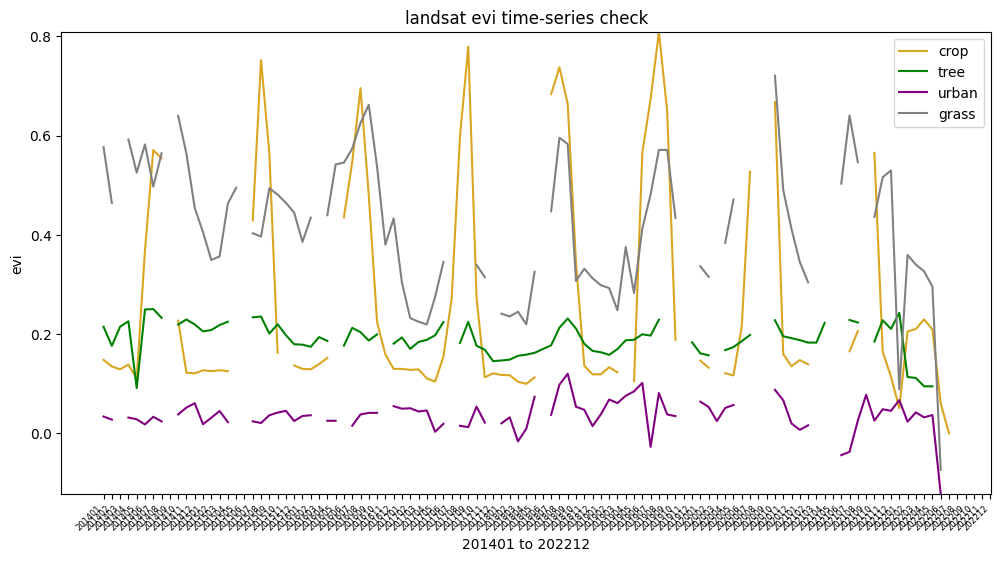

In [100]:
crop1=click_to_coords('-33.7119 : 18.64633','crop')
tree=click_to_coords('-33.62638 : 18.54511','tree')
urba=click_to_coords('-33.92695 : 18.62674', 'urban')
grass=click_to_coords('-33.92357 : 18.60557', 'grass')
web_coord_list=[crop1, tree, urba, grass]

vrt_dir='/home/sandbox-cel/capeTown/monthly/landsat/vrts/'     

for VI in ['evi']: ## 'ndmi1', 'savi'
    pic = plot_TS_filled(vrt_dir=vrt_dir, grid_file=grid_file, web_coord_list=web_coord_list, VI=VI)
    pic.savefig('/home/l_sharwood/code/bash/pic'+VI.upper()+'.png')

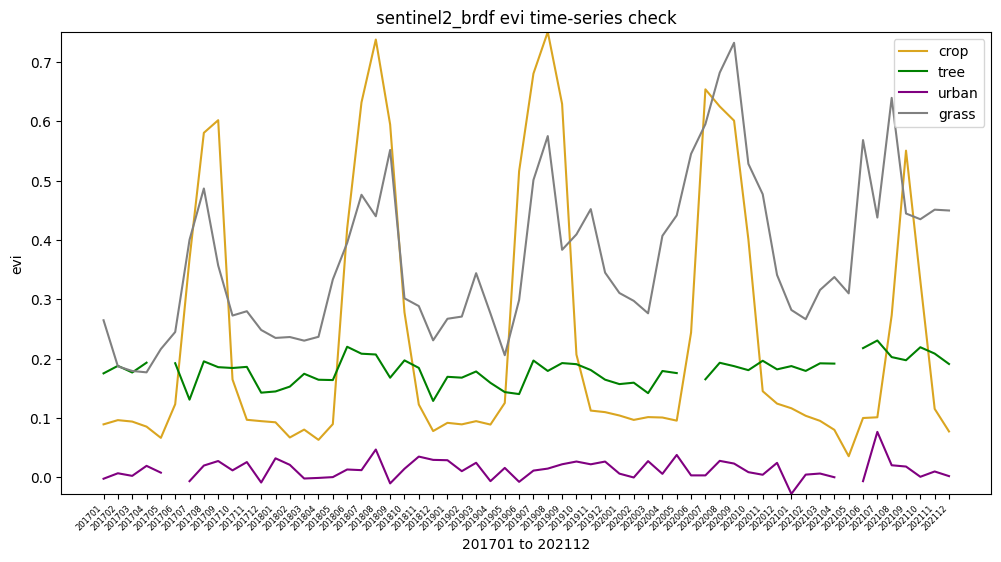

In [93]:
crop1=click_to_coords('-33.7119 : 18.64633','crop')
tree=click_to_coords('-33.62638 : 18.54511','tree')
urba=click_to_coords('-33.92695 : 18.62674', 'urban')
grass=click_to_coords('-33.92357 : 18.60557', 'grass')
web_coord_list=[crop1, tree, urba, grass]

vrt_dir='/home/sandbox-cel/capeTown/monthly/sentinel2_brdf/vrts/'     

for VI in ['evi']: ## 'ndmi1', 'savi'
    pic = plot_TS_filled(vrt_dir=vrt_dir, grid_file=grid_file, web_coord_list=web_coord_list, VI=VI)
    pic.savefig('/home/l_sharwood/code/bash/pic'+VI.upper()+'.png')

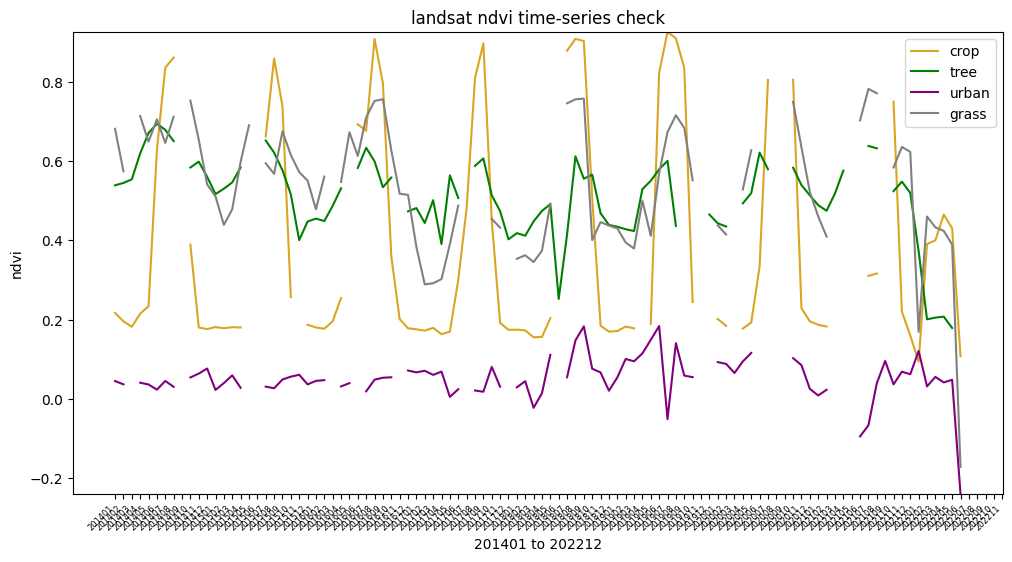

In [101]:
crop1=click_to_coords('-33.7119 : 18.64633','crop')
tree=click_to_coords('-33.62638 : 18.54511','tree')
urba=click_to_coords('-33.92695 : 18.62674', 'urban')
grass=click_to_coords('-33.92357 : 18.60557', 'grass')
web_coord_list=[crop1, tree, urba, grass]

vrt_dir='/home/sandbox-cel/capeTown/monthly/landsat/vrts/'     

for VI in ['ndvi']: ## 'ndmi1', 'savi'
    pic = plot_TS_filled(vrt_dir=vrt_dir, grid_file=grid_file, web_coord_list=web_coord_list, VI=VI)
    pic.savefig('/home/l_sharwood/code/bash/pic'+VI.upper()+'.png')

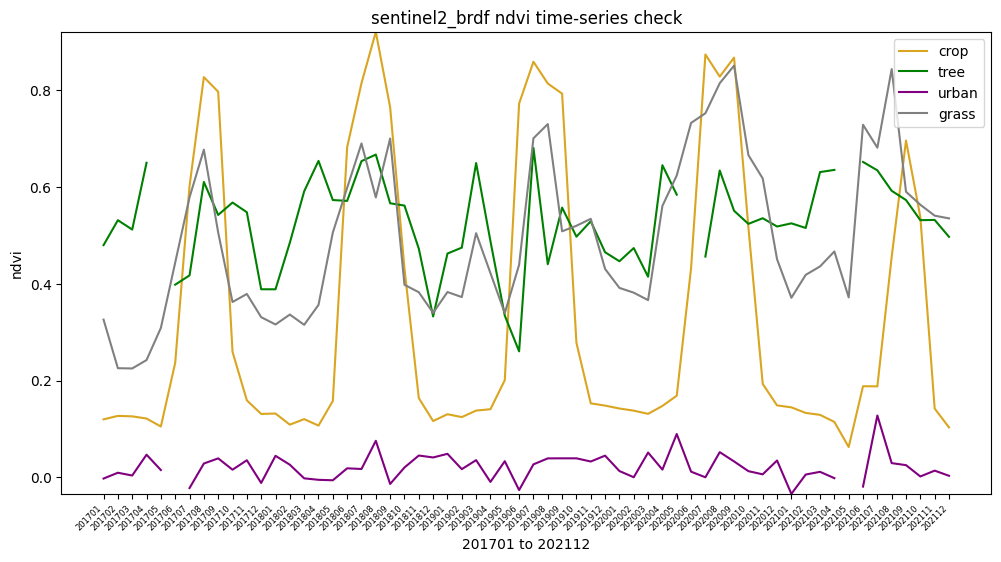

In [94]:
crop1=click_to_coords('-33.7119 : 18.64633','crop')
tree=click_to_coords('-33.62638 : 18.54511','tree')
urba=click_to_coords('-33.92695 : 18.62674', 'urban')
grass=click_to_coords('-33.92357 : 18.60557', 'grass')
web_coord_list=[crop1, tree, urba, grass]

vrt_dir='/home/sandbox-cel/capeTown/monthly/sentinel2_brdf/vrts/'     

for VI in ['ndvi']: ## 'ndmi1', 'savi'
    pic = plot_TS_filled(vrt_dir=vrt_dir, grid_file=grid_file, web_coord_list=web_coord_list, VI=VI)
    pic.savefig('/home/l_sharwood/code/bash/pic'+VI.upper()+'.png')

#### NDMI1 vs NDMI2 plot order:  
1. NDMI1 Landsat  
2. NDMI1 Sentinel-2  
3. NDMI2 Landsat  
4. NDMI2 Sentinel-2  

- *NDMI1 & NDMI2 (using SWIR1 and SWIR2) both distinguish landcover classes well*    
- *NDMI vs NDMI2... NDMI2 vegetation VI values look to be shifted ~0.2 higher than NDMI1, and distinguish @ least grass from tree a little better, maybe*  
- *For Sentinel-2, NDMI1 & NDMI2 both drop off in July 2017... maybe something wrong with an image's SWIR bands in that month because other VIs (that don't use SWIR bands) and Landsat NDMIs don't show that drop*   


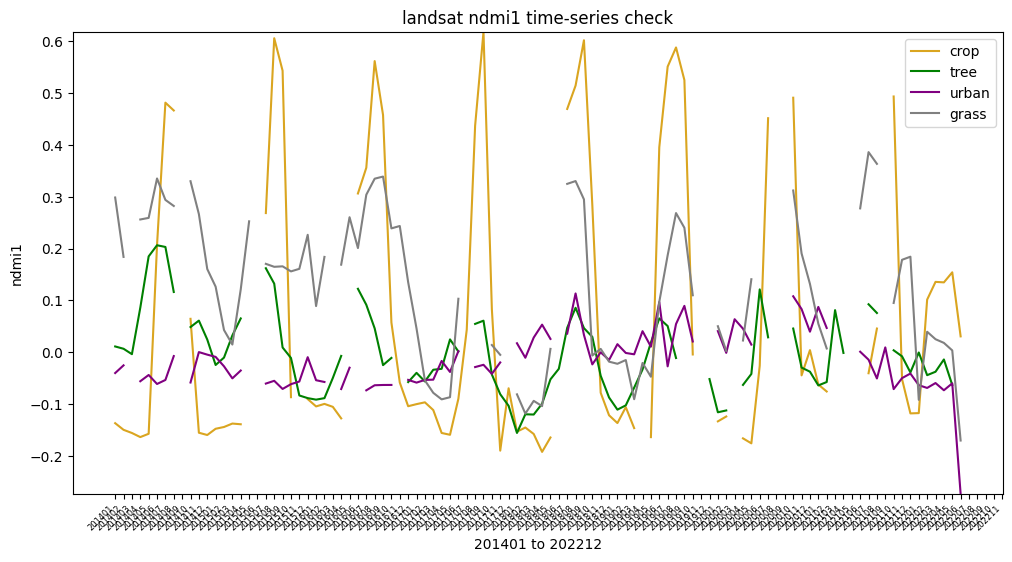

In [98]:
crop1=click_to_coords('-33.7119 : 18.64633','crop')
tree=click_to_coords('-33.62638 : 18.54511','tree')
urba=click_to_coords('-33.92695 : 18.62674', 'urban')
grass=click_to_coords('-33.92357 : 18.60557', 'grass')
web_coord_list=[crop1, tree, urba, grass]

vrt_dir='/home/sandbox-cel/capeTown/monthly/landsat/vrts/'     

for VI in ['ndmi1']: ## 'ndmi1', 'savi'
    pic = plot_TS_filled(vrt_dir=vrt_dir, grid_file=grid_file, web_coord_list=web_coord_list, VI=VI)
    pic.savefig('/home/l_sharwood/code/bash/pic'+VI.upper()+'.png')

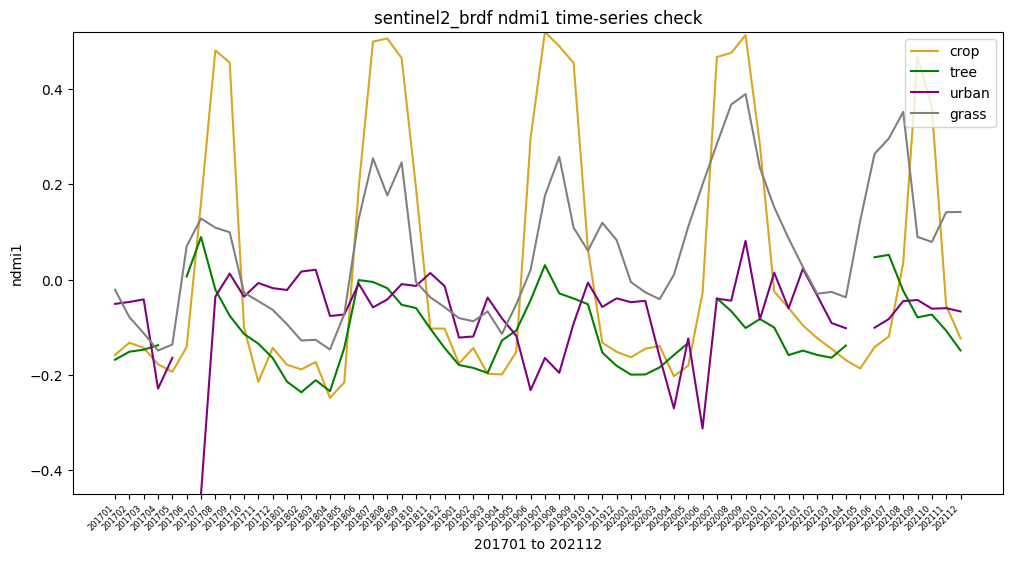

In [99]:
crop1=click_to_coords('-33.7119 : 18.64633','crop')
tree=click_to_coords('-33.62638 : 18.54511','tree')
urba=click_to_coords('-33.92695 : 18.62674', 'urban')
grass=click_to_coords('-33.92357 : 18.60557', 'grass')
web_coord_list=[crop1, tree, urba, grass]

vrt_dir='/home/sandbox-cel/capeTown/monthly/sentinel2_brdf/vrts/'     

for VI in ['ndmi1']: ## 'ndmi1', 'savi'
    pic = plot_TS_filled(vrt_dir=vrt_dir, grid_file=grid_file, web_coord_list=web_coord_list, VI=VI)
    pic.savefig('/home/l_sharwood/code/bash/pic'+VI.upper()+'.png')

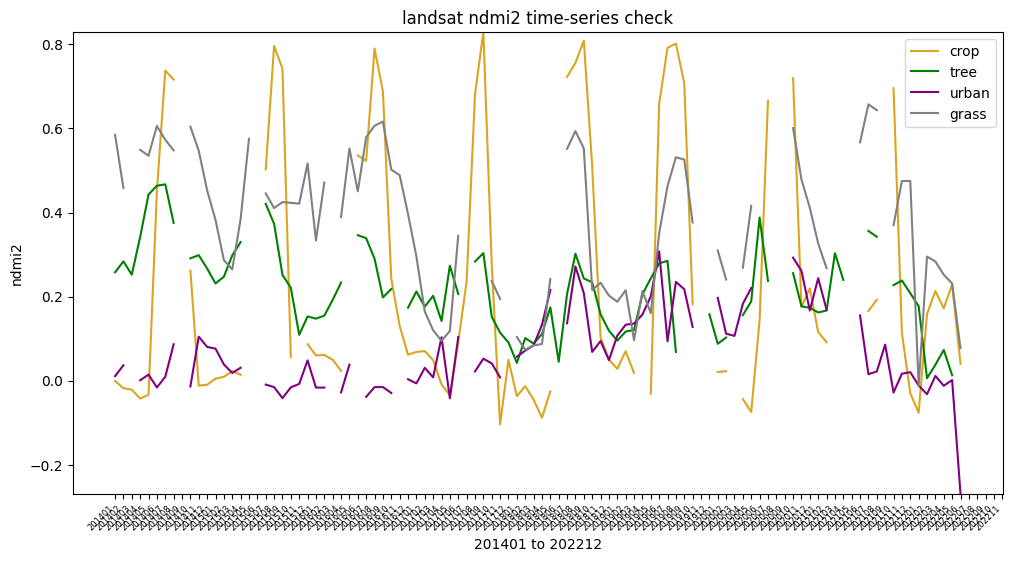

In [97]:
crop1=click_to_coords('-33.7119 : 18.64633','crop')
tree=click_to_coords('-33.62638 : 18.54511','tree')
urba=click_to_coords('-33.92695 : 18.62674', 'urban')
grass=click_to_coords('-33.92357 : 18.60557', 'grass')
web_coord_list=[crop1, tree, urba, grass]

vrt_dir='/home/sandbox-cel/capeTown/monthly/landsat/vrts/'     

for VI in ['ndmi2']: ## 'ndmi1', 'savi'
    pic = plot_TS_filled(vrt_dir=vrt_dir, grid_file=grid_file, web_coord_list=web_coord_list, VI=VI)
    pic.savefig('/home/l_sharwood/code/bash/pic'+VI.upper()+'.png')

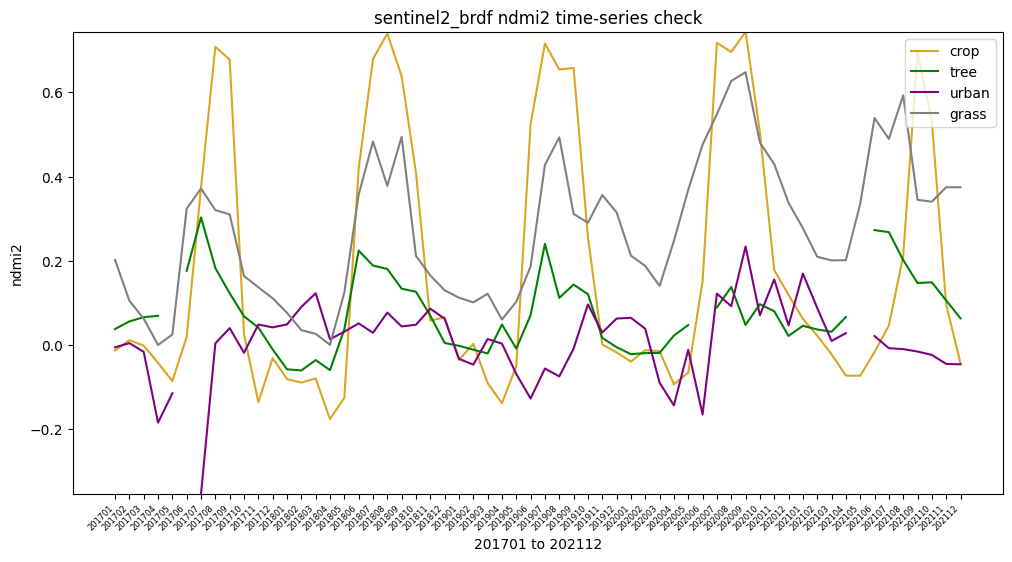

In [95]:
crop1=click_to_coords('-33.7119 : 18.64633','crop')
tree=click_to_coords('-33.62638 : 18.54511','tree')
urba=click_to_coords('-33.92695 : 18.62674', 'urban')
grass=click_to_coords('-33.92357 : 18.60557', 'grass')
web_coord_list=[crop1, tree, urba, grass]

vrt_dir='/home/sandbox-cel/capeTown/monthly/sentinel2_brdf/vrts/'     

for VI in ['ndmi2']: ## 'ndmi1', 'savi'
    pic = plot_TS_filled(vrt_dir=vrt_dir, grid_file=grid_file, web_coord_list=web_coord_list, VI=VI)
    pic.savefig('/home/l_sharwood/code/bash/pic'+VI.upper()+'.png')

## Steps to prep decile shapes

### 1) Dissolve by decile16:
1. Join decile16 attribute in propval_coords.csv with parcel shapefile using liskey unique ID
2. Dissolve/unary union ~600,000 parcel polygons w/ the same decile16 value to create <b>decile multipolygons</b>

In [51]:
## use property values from propval_coords.csv to create a list of parcel-unique-IDs in each decile (for each year). 
################################

prop_vals_csv = '/home/sandbox-cel/capeTown/vector/propval_coords.csv'
in_shp = '/home/sandbox-cel/capeTown/vector/isiskey2015_4326.shp'

################################

prop_bounds = gpd.read_file(in_shp)
prop_bounds=prop_bounds[prop_bounds['isiskey'] != 0]

property_vals = pd.read_csv(prop_vals_csv)
property_vals = property_vals[[i for i in property_vals.columns.to_list() if "Unnamed: 0" not in i]]
print('number of IDs', len(property_vals))
print('number of unique IDs', len(list(set(property_vals.index))))
parcels_wDecile = prop_bounds.set_index("isiskey").join(property_vals.set_index("liskey")[['decile16']])
parcels_wDecile=parcels_wDecile[parcels_wDecile['decile16'] > 0]
print('number of shapes with decile16 values based on unique ID', len(parcels_wDecile))
deci16_utm = parcels_wDecile.dissolve('decile16').to_crs(32734)
deci16_utm['fullArea'] = deci16_utm.area
display(deci16_utm)
deci16_utm.to_file(in_shp.replace("isiskey2015_4326.shp", "deci16_32734.shp"))

number of IDs 639598
number of unique IDs 639598
number of shapes with decile16 values based on unique ID 620292


,geometry,area
decile16,,
1.0,"MULTIPOLYGON (((267326.443 6207882.590, 267327...",1.005426e+07
2.0,"MULTIPOLYGON (((264506.699 6213025.643, 264509...",9.121173e+06
3.0,"MULTIPOLYGON (((256318.819 6218348.619, 256326...",1.183215e+07
4.0,"MULTIPOLYGON (((256236.467 6217419.780, 256231...",1.456928e+07
5.0,"MULTIPOLYGON (((256406.259 6217400.651, 256413...",1.765068e+07
6.0,"MULTIPOLYGON (((264353.629 6213090.750, 264358...",2.291141e+07
7.0,"MULTIPOLYGON (((258508.373 6212297.902, 258478...",2.979969e+07
8.0,"MULTIPOLYGON (((258560.717 6212233.841, 258533...",3.391739e+07
9.0,"MULTIPOLYGON (((253094.402 6218369.640, 253062...",4.421327e+07


### 2) Remove (mask or clip) area from decile multipolygons based on landcover map, [South Africa National Landcover Dataset (SANLCD)](https://egis.environment.gov.za/sa_national_land_cover_datasets)
* *landcover types to remove are (?) those that are not affected by ppl using water, i.e. natural vegetation classes (flooded wetlands/natural shrubs/forests) but should include those that may be irrigated & use surface water (grass fields/lawns). planted forests are included because they're irrigated (?). open water bodies masked bcuz open water not measured by these VIs*   
* <b>to-do: try removing different landcover classes from mask</b>  

#### SANLCD (vs ESA Worldcover):    
* years: 2014, 2018, 2020 (vs 2020, 2021)   
  * *SANLCD better overlaps with study period, and offers option to additionally mask certain landcover class transitions*   
* pixel size: 30m, 20m, 20m (vs 10m, 10m...made from Sentinel-2 and Sentinel-1)    
  * *using a mask that has a smaller pixel size (finer spatial resolution), i.e. 10m, than the pixel size of time-series imagery, i.e. 30m, probably won't have that added benefit of finer spatial resolution because the larger 30m pixel from the time-series imagery is still recording signal from everything withinin that 30m x 30m area.*  
* classes: SANLCD has more classes that are region-specific (vs broad/global)   
  * *training data used to create classification SANLCD model were also probably much denser over the study area --> higher qualty map*  


In [90]:
recode_csv= '/home/l_sharwood/code/SA_NLCD_18_20.csv'
recode=pd.read_csv(recode_csv)
old_new_dict = dict(zip(recode['old'], recode['new']))
name_dict = dict(zip(recode['name'], recode['new']))

values={0:[], 1:[], 2:[]}
for k in name_dict:
    values[name_dict[k]].append(k)
d = pd.DataFrame.from_dict(values, orient='index').T
d.columns=['noData', 'remove', 'keep']
print('remove classes (1):\n', '[{0}]'.format(', '.join(map(str, d['remove'][:-1]))))
print(' ')
print('keep classes (2):\n', '[{0}]'.format(', '.join(map(str, d['keep']))))
## Residential formal (bare) is majority of decile 1-4 area. Residential formal (low veg / grass) is majority of decile 5-10 area.

remove classes (1):
 [Contiguous (indigenous) Forest (combined very high, high, medium), Contiguous Low Forest & Thicket (combined classes), Dense Forest & Woodland (35 - 75% cc), Open Woodland (10 - 35% cc), Temporary Unplanted Forest, Low Shrubland (other regions), Low Shrubland (Fynbos), Low Shrubland (Succulent Karoo), Low Shrubland (Nama Karoo), Sparsely Wooded Grassland (5 - 10% cc), Natural Grassland, Natural Rivers, Natural Estuaries & Lagoons, Natural Ocean, Coastal, Natural Lakes, Natural Pans (flooded @ obsv time), Artificial Dams (incl. canals), Artificial Sewage Ponds, Artificial Flooded Mine Pits, Herbaceous Wetlands (currently mapped), Herbaceous Wetlands (previous mapped extent), Mangrove Wetlands, Natural Rock Surfaces, Dry Pans, Eroded Lands, Sand Dunes (terrestrial), Coastal Sand Dunes & Beach Sand, Bare Riverbed Material, Other Bare, Roads & Rail (Major Linear), Mines: Surface Infrastructure, Mines: Extraction Sites: Open Cast & Quarries combined, Mines: Extraction 

#### Landcover masking steps: 
1. download SANLCD from 2014, 2018, and 2020  
2. create mask per year: reclassify SANLCD using csv with {old:new} raster values where 0=noData, 1=remove, and 2=keep in new
4. to remove pixels that changed from a 'remove' to 'keep' class, or vice vera between two years-- create a combined mask where areas that belongs to a 'remove' class in either year are removed     
    * test 2014/2020, 2014/2018, and 2018/2020  
    * *this doesn't consider the fact that different vegetation types have different VI values, so changing landcover types year-to-year within the keep category (i.e. grass in 2014 to shrub in 2018) would change the VI and not be related to water use (i.e. grass is higher than shrubs, but both are in the keep category)*
    * <b>to-do: check year-to-year-transitions and % of decile covered by each landcover class</b> 
5. convert raster -> vector then clip polygons with raster values of 1 out of the property-value-decile-multipolygons   

In [ ]:
in_rast = r'C:\Users\Lauren\Documents\capeTown\SA_NLC\SA_NLC_2020_GEO.tif'
in_rast = r'C:\Users\Lauren\Documents\capeTown\SA_NLC\SA_NLC_2018_GEO.tif'
## in_rast = r'C:\Users\Lauren\Downloads\SALandCover_ReprojectedGEO_2013_GTI_35Classes\Reprojected GEO\dea_cardno_2014_sa_lcov_geo_vs2b_pivot-corr.tif'
out_dir = r'C:\Users\Lauren\Documents\capeTown\SA_NLC'
out_rast = os.path.join(out_dir, os.path.basename(in_rast).replace('.tif', '_clip.tif'))

grid_file = r'C:\Users\Lauren\Desktop\cape_grid_utm32S.gpkg'

##################

bounds_gdf = gpd.read_file(grid_file)
bounds_proj = bounds_gdf.to_crs(4326)
bound_geom = bounds_proj.dissolve().geometry
bounds = (float(bound_geom.bounds['minx']), float(bound_geom.bounds['maxx']), float(bound_geom.bounds['miny'] ), float(bound_geom.bounds['maxy']))
with rio.open(in_rast) as src:
    out_meta = src.meta.copy()
    rast_crs = src.crs
    grid_gt = src.transform
    src_offset = windowed_read(grid_gt, bounds)
    arr = src.read(1, window=Window(src_offset[0], src_offset[1], src_offset[2], src_offset[3]))
    print(arr)
    new_gt = rio.Affine(grid_gt[0], grid_gt[1], (grid_gt[2] + (src_offset[0] * grid_gt[0])), 0.0, grid_gt[4], (grid_gt[5] + (src_offset[1] * grid_gt[4])))
    out_meta.update({'transform': new_gt, 'width':arr.shape[1], 'height':arr.shape[0]})
    with rio.open(out_rast, 'w', **out_meta) as dst:
        dst.write(arr, 1)

## reproject to UTM
reproject_raster(out_crs='EPSG:32734', in_path=out_rast, overwrite=False)

#### % of surface area (% of pixels in the landcover raster clipped to CapeTown) that would be removed (1-masked) and kept (2-unmasked)...
* based on SINGLE recoded NLCD map-- 2014, 2018 and 2020 (next three pie charts)  
    * *masking out a lot out of sample-- 37, 37, and 39% in 2014, 2018 and 2020*
    * *makes sense that a lot of the landcover is being masked out... but much of the urban areas where there properties are clustered have remained*   
    * *ideally don't see much difference in landcover being masked out between years*
    * *interesting that there's a 2% jump in area masked from 2018 to 2020... would expect a larger jump between 14/18 or 14/20, where there's a larger time gap between products... and change in spatial resolution and probably sensor*
* based on COMBINED recoded landcover map (2014, 2018, 2020) transitions (following three pie charts)  
    * remove pixel if it was in a <i>mask</i> class in 2014 <b>or</b> 2018   
    * remove pixel if it was in a <i>mask</i> class in 2018 <b>or</b> 2020    
    * remove pixel if it was in a <i>mask</i> class in 2014 <b>or</b> 2020 
    

{'SA_NLC30b_2014_32734.tif': array([2053741, 5676554, 3347560], dtype=int64)}
{'SA_NLC_2018_32734.tif': array([ 2834851, 17069167, 10028143], dtype=int64)}
{'SA_NLC_2020_32734.tif': array([ 2834851, 16470156, 10627154], dtype=int64)}


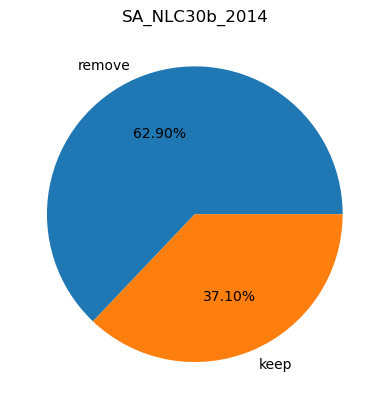

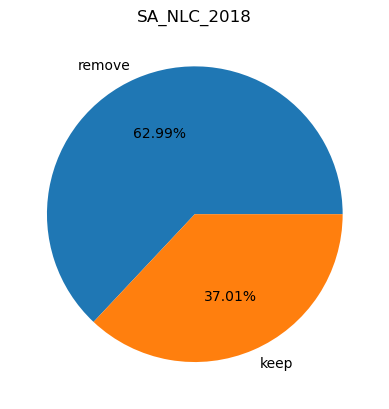

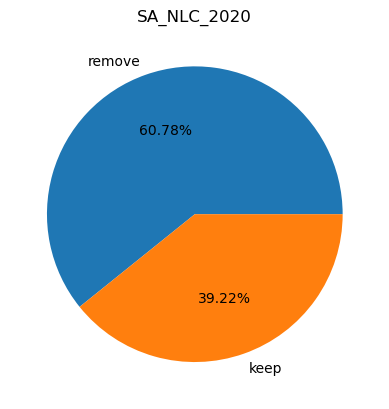

In [ ]:
mask_counts={}
for in_rast, recode_csv in [[r'C:\Users\Lauren\Documents\capeTown\SA_NLC\SA_NLC30b_2014_32734.tif',
                            r'C:\Users\Lauren\Documents\capeTown\SA_NLCD_14.csv'],
                            [r'C:\Users\Lauren\Documents\capeTown\SA_NLC\SA_NLC_2018_32734.tif',
                            r'C:\Users\Lauren\Documents\capeTown\SA_NLCD_18_20.csv'],
                            [ r'C:\Users\Lauren\Documents\capeTown\SA_NLC\SA_NLC_2020_32734.tif',
                            r'C:\Users\Lauren\Documents\capeTown\SA_NLCD_18_20.csv']
                            ]:
    recode=pd.read_csv(recode_csv)
    old_new_dict = dict(zip(recode['old'], recode['new']))
    name_dict = dict(zip(recode['name'], recode['new']))
    #display(name_dict)
    out_rast = in_rast.replace('.tif', '_mask.tif')
    with rio.open(in_rast) as src:
        arr = src.read()
        ## reclassify raster using recode dictionary
        new_arr = np.vectorize(old_new_dict.get)(arr)
        gt = src.transform
        rast_crs = src.crs
        out_meta = src.meta.copy()
    with rio.open(out_rast, 'w', **out_meta) as dst:
        dst.write(new_arr)
    unique, counts = np.unique(new_arr, return_counts=True)
    print({os.path.basename(in_rast):counts})
    mask_counts.update({os.path.basename(in_rast):counts[1:3]})    
for maskYr in list(mask_counts.keys()):
    plt.title(maskYr.replace('_32734.tif', ''))
    data=mask_counts.get(maskYr)
    plt.pie(data, labels=['remove', 'keep'], autopct='%.2f%%')
    plt.show()


{'1418': array([16229199,  7568892], dtype=int64),
 '1820': array([16470992,  9755580], dtype=int64),
 '1420': array([15781967,  8016127], dtype=int64)}

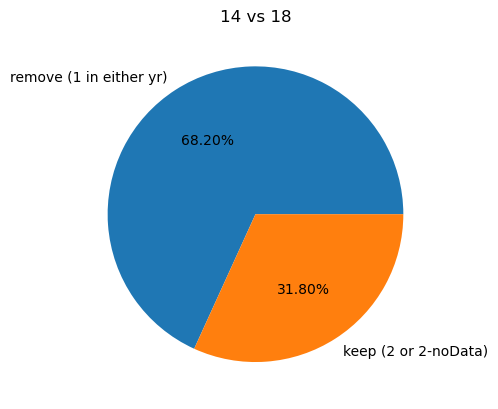

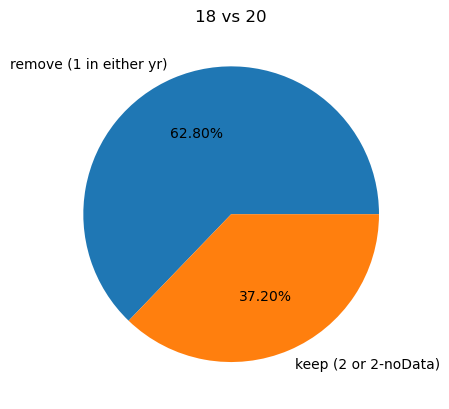

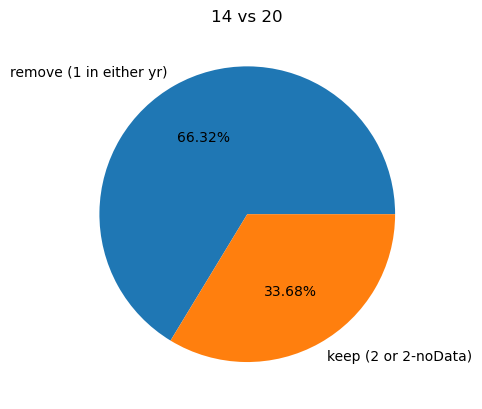

In [81]:
## mask 2014 -> 2018 values

compar_counts={}
for compar, in_rast, in_rast2 in [["1418", 
                                 r"C:\Users\Lauren\Documents\capeTown\SA_NLC\SA_NLC30b_2014_32734_mask_20m.tif", ## resample 2014 to 20m to match pixels w/ 2018 & 2020
                                 r"C:\Users\Lauren\Documents\capeTown\SA_NLC\SA_NLC_2018_32734_mask.tif"],
                                 ["1820", 
                                 r"C:\Users\Lauren\Documents\capeTown\SA_NLC\SA_NLC_2018_32734_mask.tif",
                                r"C:\Users\Lauren\Documents\capeTown\SA_NLC\SA_NLC_2020_32734_mask.tif"],
                                 ["1420", 
                                 r"C:\Users\Lauren\Documents\capeTown\SA_NLC\SA_NLC30b_2014_32734_mask_20m.tif", ## resample 2014 to 20m to match pixels w/ 2018 & 2020
                                 r"C:\Users\Lauren\Documents\capeTown\SA_NLC\SA_NLC_2020_32734_mask.tif"]
                                 ]:
    

    grid_file = r"C:\Users\Lauren\Desktop\cape_grid_utm32S.gpkg"
    bounds_gdf = gpd.read_file(grid_file)
    bounds_proj = bounds_gdf.to_crs(32734)
    bound_geom = bounds_proj.dissolve().geometry
    bounds = (float(bound_geom.bounds['minx']), float(bound_geom.bounds['maxx']), float(bound_geom.bounds['miny'] ), float(bound_geom.bounds['maxy']))

    with rio.open(in_rast) as tmp:
        out_meta = tmp.meta.copy()
        rast_crs = tmp.crs
        grid_gt = tmp.transform
        src_offset = windowed_read(grid_gt, bounds)
        tmp_arr = tmp.read(1, window=Window(src_offset[0], src_offset[1], src_offset[2], src_offset[3])).astype(int)
        new_gt = rio.Affine(grid_gt[0], grid_gt[1], (grid_gt[2] + (src_offset[0] * grid_gt[0])), 0.0, grid_gt[4], (grid_gt[5] + (src_offset[1] * grid_gt[4])))

    with rio.open(in_rast2) as tmp2:
        tmp_arr2 = tmp2.read(1)
        out_meta2 = tmp2.meta.copy()
        rast_crs2 = tmp2.crs
        grid_gt2 = tmp2.transform
        src_offset2 = windowed_read(grid_gt2, bounds)
        tmp_arr2 = tmp2.read(1, window=Window(src_offset2[0], src_offset2[1], src_offset2[2], src_offset2[3])).astype(int)
        new_gt = rio.Affine(grid_gt2[0], grid_gt2[1], (grid_gt2[2] + (src_offset2[0] * grid_gt2[0])), 0.0, grid_gt2[4], (grid_gt2[5] + (src_offset2[1] * grid_gt2[4])))

    # Initialize a new array with zeros
    transition = np.zeros_like(tmp_arr)
    # Handle the transitions based on the specified conditions
    transition[np.where( (tmp_arr == 1) & (tmp_arr2 == 1) )] = 1 ## 1 where they should both be masked out
    transition[np.where( (tmp_arr == 1) & (tmp_arr2 == 2) )] = 1 ## 1 where they went from 1 to 2
    transition[np.where( (tmp_arr == 2) & (tmp_arr2 == 1) )] = 1 ## 1 where they went from 2 to 1
    transition[np.where( (tmp_arr == 2) & (tmp_arr2 == 2) )] = 2 ## 2 where they should stay both times
    transition[np.where( (tmp_arr == 2) & (tmp_arr2 == 0) )] = 2 ## 2 where it was 2 then nothing 
    transition[np.where( (tmp_arr == 0) & (tmp_arr2 == 2) )] = 2 ## 2 where it was nothing then 2 
    transition[np.where( (tmp_arr == 0) & (tmp_arr2 == 0) )] = 0 ## 0 where it was nothing then nothing 

    out_meta.update({"transform":new_gt, "height":transition.shape[0], "width":transition.shape[1]})
    out_dir = r"C:\Users\Lauren\Documents\capeTown\SA_NLC"
    out_fi = os.path.join(out_dir, "transitions_"+compar+".tif") ## CHANGE YEARS 
    with rio.open(out_fi, 'w', **out_meta) as dst:
        dst.write(transition, indexes=1)

    ###################################################################
    unique, counts = np.unique(transition, return_counts=True)
    compar_counts.update({compar:counts[1:3]})
    
display(compar_counts)

import matplotlib.pyplot as plt 
import seaborn 

for comparVersion in list(compar_counts.keys()):
    plt.title(comparVersion[:2]+" vs "+comparVersion[2:])
    data=compar_counts.get(comparVersion)
    plt.pie(data, labels=['remove (1 in either yr)', 'keep (2 or 2-noData)'], autopct='%.2f%%')
    plt.show()


#### bar chart showing area per decile multipolygon before and after landcover mask (in-sample area that's removed in blue)
* 3 masks (14/18, 18/20, 14/20) for decile16 
* *most area being removed from top deciles*
* *unexpectedly, 14/18 transition removes the most from the upper deciles mostly, and 14/20 transition removes the least*

In [ ]:
# ## quicker clipping in Arc: 
# - Raster to Polygon
# - delete raster val of 1
# - clip (analysis) decile_sub.shp w/ remaining mask shape (raster vals 0 & 2)

## convert raster to polygon then clip parcels based on combined mask

################################
property_shapes = r'C:\Users\Lauren\Documents\capeTown\isiskey2015\isiskey2015_32734_sub.shp'
property_UTM = gpd.read_file(property_shapes)

################################

## for combined mask (pixels in Keep class and pixels that didn't change between binary keep classes) 
## raster to vector 
shapes = ({'properties': {'raster_val': v}, 'geometry': s} for i, (s, v) in enumerate(shapes(transition_array, mask=None, transform=gt)))
LC_vectors = gpd.GeoDataFrame.from_features(list(shapes), crs=rast_crs)
## only keep polygons that == 1 (to remove/mask)
LC_mask = LC_vectors[LC_vectors['raster_val'] == 1.0]
print(LC_mask)
LC_mask.to_file(property_shapes[:-4]+ 'LCmask141820_32734.shp')
## overlay-difference to clip landcover mask out of property polygons 
LC_mask_props = property_UTM.overlay(LC_mask, how='difference')
LC_mask_props['mskArea'] = LC_mask_props.area
LC_mask_props.to_file(property_shapes.replace('.shp', '_clip.shp')) ## isiskey2015_32734_Mas141820
LC_mask_props

% of area left per decile
0    87.590657
1    92.772975
2    93.938759
3    92.183332
4    90.398730
5    89.661823
6    88.992297
7    88.983601
8    89.348495
9    68.417631
Name: deci16_mask1418, dtype: float64


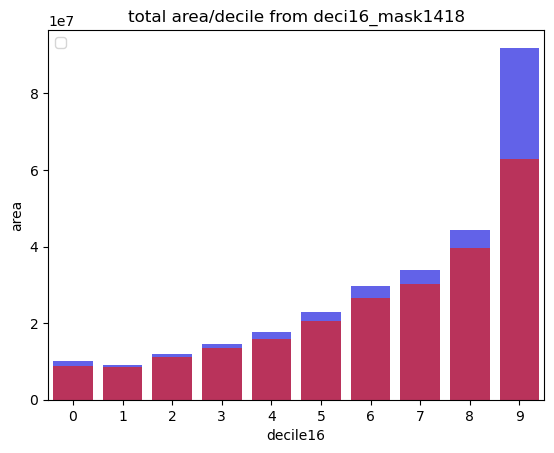

% of area left per decile
0    91.403118
1    98.294522
2    96.870005
3    96.151910
4    95.607415
5    93.924539
6    92.204406
7    92.459379
8    93.686362
9    78.080463
Name: deci16_mask1820, dtype: float64


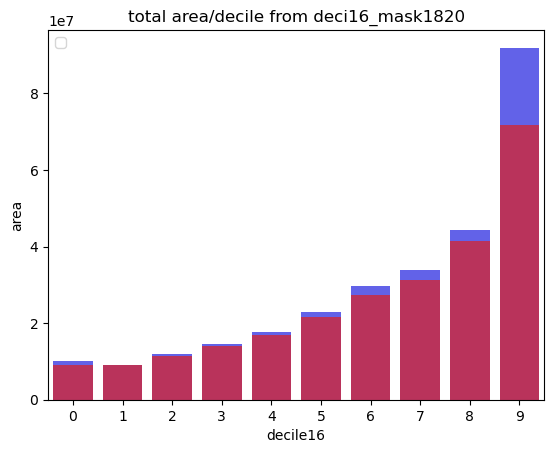

% of area left per decile
0    89.723180
1    93.871538
2    96.499305
3    94.841910
4    94.293745
5    95.195576
6    96.065854
7    94.895316
8    94.462359
9    79.993319
Name: deci16_mask1420, dtype: float64


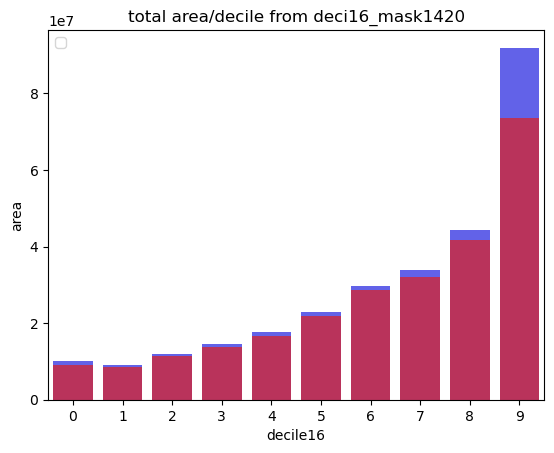

In [74]:
decile_areasO={}
decile_areasN={}
for inFile in [ r"C:\Users\Lauren\Documents\capeTown\isiskey2015\deci16_mask1418_32734.shp", 
               r"C:\Users\Lauren\Documents\capeTown\isiskey2015\deci16_mask1820_32734.shp",
               r"C:\Users\Lauren\Documents\capeTown\isiskey2015\deci16_mask1420_32734.shp"
              ]:
    in_gdf = gpd.read_file(inFile)
    decilePolys=in_gdf[in_gdf['decile16'] >= 0]
    decilePolys['mskArea'] = decilePolys.area
    newAreas = decilePolys.groupby([IDcol], as_index=False)['mskArea'].sum()['mskArea'] 
    oldAreas = decilePolys.groupby([IDcol], as_index=False)['area'].sum()['area']    
    decile_areasO.update({os.path.basename(inFile).replace("_32734.shp", ""):oldAreas.to_list()})
    decile_areasN.update({os.path.basename(inFile).replace("_32734.shp", ""):newAreas.to_list()})

    decilePolys= decilePolys.drop(columns=[col for col in decilePolys if col not in ["geometry", IDcol, 'area', 'mskArea' ]])
        
dfO = pd.DataFrame( decile_areasO)
dfN = pd.DataFrame( decile_areasN)

for col in dfO.columns.to_list():
    old = dfO[col]
    new = dfN[col]
    print('% of area left per decile')
    print(dfN[col]/(dfO[col])*100)    
    
    ax = plt.subplots()
    ax = sns.barplot(x=old.index, y=dfO[col], color='b', alpha=0.7)
    ax = sns.barplot(x=old.index, y=dfN[col], color='r', alpha=0.7)
    ax.set(xlabel="decile16", ylabel="area", title="total area/decile from "+col.replace("liskey2015_", ""))
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, ['new', 'old'])
    plt.show()

## 3) Extract decile multipolygon average VI from each month's greenness vrt mosaic  

In [ ]:
## month_dir='/home/sandbox-cel/capeTown/monthly/sentinel2_brdf/vrts' 
month_dir='/home/sandbox-cel/capeTown/monthly/landsat/vrts' 
## month_dir='/home/sandbox-cel/capeTown/monthly/sentinel2_refl/vrts' 
    
endYr=2021
if "sentinel2" in month_dir:
    startYr=2017
elif "landsat" in month_dir:
    startYr=2014
for inShp in ["/home/sandbox-cel/capeTown/vector/deci16_mask1418_32734.shp","/home/sandbox-cel/capeTown/vector/deci16_mask1820_32734.shp", "/home/sandbox-cel/capeTown/vector/deci16_mask1420_32734.shp"]:
    for VI in ['evi','ndvi', 'ndmi1','ndmi2', 'savi' ]:
        sensor_version = month_dir.split('/')[-2]
        outFi=inShp.replace('.shp', '_'+sensor_version+'_'+VI+'_z.csv')
        print(outFi)
        dfs=[]
        if not os.path.exists(outFi):
            monthly_deciles = {}
            for year in list(range(startYr, endYr+1, 1)):
                for month in list(range(1, 13, 1)):
                    date = str(year)+str(month).zfill(2)
                    monthRast = sorted([os.path.join(month_dir, file) for file in os.listdir(month_dir) if VI+'_'+date in file])[0]
                    col_name = '-'.join(os.path.basename(monthRast).replace('.vrt', '').split('_')[1:])   
                    print(col_name)
                    decile_means = zonal_stats(inShp, monthRast, stats='mean')
                    ## dictionary w/ date as key, list of means as value
                    monthly_deciles.update({date:[i['mean'] for i in decile_means]})
                    df = pd.DataFrame.from_dict(monthly_deciles)
                    dfs.append(df)
                print(dfs[-1])
        dfs_comb=pd.concat(dfs, axis=0)
        print(dfs_comb.tail(10))
        dfs_comb.tail(10).to_csv(outFi)


In [4]:
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

def plot_TS_decile(TS_csv):
    dfs_comb = pd.read_csv(TS_csv, header=[0], index_col=[0])
    df = dfs_comb.T   
    color_scale = px.colors.sample_colorscale("Burg", 10)
    fig = go.Figure(layout=go.Layout( autosize=True,  height=500 ))
    for dec in df.columns.to_list():
        fig.add_trace( go.Scatter(x=df.index, y=df[dec], name='decile '+str(dec+1), marker_color = color_scale[dec]))
    fig.update_layout( title_text=' '.join(os.path.basename(TS_csv)[:-6].split('_')).replace("32734 ", "").replace("brdf ", "") )
    fig.update_yaxes(title_text='Avg Decile '+ os.path.basename(TS_csv)[1:-6].split('_')[-1].upper())
    fig.write_html(TS_csv.replace(".csv", ".html"))
    fig.show()


In [ ]:
## COMPARE OPTIONS
VIs=['evi','ndvi', 'ndmi1','ndmi2', 'savi']
sensors=["sentinel2", "landsat"]
masks=["1418", "1820", "1420"]

in_dir = "/home/sandbox-cel/capeTown/vector"
done_csvs =sorted([i for i in os.listdir(in_dir) if (i.endswith("_z.csv") and (i.split("_")[-2] in VIs and i.split("_")[1][-4:] in masks and i.split("_")[3] in sensors))])
print(done_csvs)
for done_csv in done_csvs:
    TS_csv = os.path.join(in_dir, done_csv)
    plot_TS_decile(TS_csv)

### Compare sensors (Sentinel2 vs Landsat)
- *Sentinel2 looks a lot smoother-- could be partially the lower data density seen in single pixel tine-series*  
- *amplitude of spetra is muted & greenness values are a lot lower than pure landcover spectra from single pixels (top of doc) because a lot of the signal being recorded here is urban/pavement*  
- control VI (EVI) and mask (2014 to 2020) **14/20 mask doesn't remove more decile boundary area, and considers the entire study period*  

In [ ]:
VIs=['evi']
sensors=["sentinel2", "landsat"] ## "sentinel2", "landsat"
masks=["1420"] ##"1418", "1820", "1420"
in_dir = "/home/sandbox-cel/capeTown/vector"
done_csvs =sorted([i for i in os.listdir(in_dir) if ((i.endswith("_z.csv") and i.split("_")[-2] in VIs) and i.split("_")[1][-4:] in masks and i.split("_")[3] in sensors)])
print(done_csvs)
for done_csv in done_csvs:
    TS_csv = os.path.join(in_dir, done_csv)
    plot_TS_decile(TS_csv)

### Sentinel2 VIs  
- control mask (2014 to 2020)
- *NDVI & EVI show more rounded peaks during wet months, vs NDMI1 & NDMI2 show dips there*   

In [ ]:
VIs=['evi','ndvi', 'ndmi1','ndmi2', 'savi' ]
sensors=["sentinel2"]
masks=["1420"]
in_dir = "/home/sandbox-cel/capeTown/vector"
done_csvs =[i for i in os.listdir(in_dir) if  (i.endswith("_z.csv") and (i.split("_")[-2] in VIs and i.split("_")[1][-4:] in masks and i.split("_")[3] in sensors))]
print(done_csvs)
for done_csv in done_csvs:
    TS_csv = os.path.join(in_dir, done_csv)
    plot_TS_decile(TS_csv)

### Landsat VIs  
- control mask (2014 to 2020)
- big drop offs (2015/06, 2020/08) in Landsat from missing time-series for a all proc tiles, or proc tiles where the majority of certain decile X area is... dropped those months and filled w/ average of month before and month after   



In [ ]:
import os
import pandas as pd
import numpy as np

## FIX 2020/08 and 2015/06 outlier from no data
VIs=['evi','ndvi', 'ndmi1','ndmi2', 'savi' ]
sensors=["landsat"]
masks=["1418", "1820", "1420"]
in_dir = "/home/sandbox-cel/capeTown/vector"
done_csvs =sorted([i for i in os.listdir(in_dir) if  (i.endswith("_z.csv") and (i.split("_")[-2] in VIs and i.split("_")[1][-4:] in masks and i.split("_")[3] in sensors))])
print(done_csvs)
for done_csv in done_csvs:
    TS_csv = os.path.join(in_dir, done_csv)
    df = pd.read_csv(TS_csv, index_col=[0])
    df2=df.copy()
    df2['202008'] = (df2['202007']+df2['202009'])/2
    df2['201506'] = (df2['201505']+df2['201507'])/2
    new_name = os.path.join(in_dir, done_csv)
    df2.to_csv(new_name)
    if "1420" in new_name:
        plot_TS_decile(new_name)


In [ ]:
VIs=['ndmi1' ]
sensors=["landsat"]
masks=["1420","1480","1820"]
in_dir = "/home/sandbox-cel/capeTown/vector"
done_csvs =[i for i in os.listdir(in_dir) if  (i.endswith("_z.csv") and (i.split("_")[-2] in VIs and i.split("_")[1][-4:] in masks and i.split("_")[3] in sensors))]
print(done_csvs)
for done_csv in done_csvs:
    TS_csv = os.path.join(in_dir, done_csv)
    plot_TS_decile(TS_csv)

## save notebook as html w/out code

In [15]:
!jupyter nbconvert ~/code/capeT-prog.ipynb --to=html  --TemplateExporter.exclude_input=True

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook /home/l_sharwood/code/capeT-prog.ipynb to html
[NbConvertApp] Writing 2549675 bytes to /home/l_sharwood/code/capeT-prog.html


In [ ]:
!jupyter nbconvert ~/code/capetown.ipynb --to=pdf  --TemplateExporter.exclude_input=True